In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torch_pconv import PConv2d  # Using the torch_pconv implementation
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split

In [2]:
def pair_color_depth_files(root_dir):
    color_dict = {}
    depth_dict = {}
    
    for directory, _, files in os.walk(root_dir):
        for f in files:
            full_path = os.path.join(directory, f)
            
            # Determine a prefix based on whether we're in a subfolder or not.
            if directory == root_dir:
                prefix_prefix = ""  # Flat structure: don't add folder name.
            else:
                prefix_prefix = os.path.basename(directory) + "_"
            
            # Check file naming conventions and strip specific suffixes:
            if f.endswith("_colors.png"):
                prefix = prefix_prefix + f.replace("_colors.png", "")
                color_dict[prefix] = full_path
            elif f.endswith("_depth.png"):
                prefix = prefix_prefix + f.replace("_depth.png", "")
                depth_dict[prefix] = full_path
            elif f.endswith(".jpg"):
                # For jpg files assume they are color images.
                prefix = prefix_prefix + f.replace(".jpg", "")
                color_dict[prefix] = full_path
            elif f.endswith(".png"):
                # For png files not already handled, assume they are depth images.
                prefix = prefix_prefix + f.replace(".png", "")
                depth_dict[prefix] = full_path
    
    pairs = []
    for prefix, cpath in color_dict.items():
        if prefix in depth_dict:
            pairs.append((cpath, depth_dict[prefix]))
    return pairs

In [3]:
class NYUDepthDataset(Dataset):
    def __init__(self, root_dir, img_size=(240, 320), transform=None, apply_mask=True):
        """
        Args:
            root_dir: Directory with color/depth pairs.
            img_size: Desired (height, width) for resizing.
            transform: Optional transforms after resizing/normalizing.
            apply_mask: Whether to create and apply a random mask.
        """
        super().__init__()
        self.root_dir = root_dir
        self.img_size = img_size  # e.g. (240, 320)
        self.transform = transform
        self.apply_mask = apply_mask

        # Create a list of (color_path, depth_path) pairs.
        self.samples = pair_color_depth_files(root_dir)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        color_path, depth_path = self.samples[idx]

        # ----- Load color image -----
        img = cv2.imread(color_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))  # (width, height)
        img = img.astype(np.float32) / 255.0

        # ----- Load depth image -----
        depth = cv2.imread(depth_path, cv2.IMREAD_UNCHANGED)
        depth = cv2.resize(depth, (self.img_size[1], self.img_size[0]))
        depth = depth.astype(np.float32) / 255.0  # Adjust normalization as needed

        # ----- Apply mask -----
        if self.apply_mask:
            mask_2d = self.create_random_mask(self.img_size)  # shape (H, W)
            # For the color image, create a 3-channel version of the mask.
            mask_3d = np.stack([mask_2d] * 3, axis=-1)

            masked_img = img.copy()
            masked_depth = depth.copy()

            # Where the mask is 0, set color pixels to black and depth to 0.
            masked_img[mask_3d == 0] = 0.0
            masked_depth[mask_2d == 0] = 0.0
        else:
            mask_2d = np.ones((self.img_size[0], self.img_size[1]), dtype=np.float32) * 255
            masked_img = img
            masked_depth = depth

        # ----- Convert to Torch Tensors -----
        # For RGB: (H, W, 3) -> (3, H, W)
        img_tensor = torch.from_numpy(img).permute(2, 0, 1)
        masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1)

        # For depth: (H, W) -> (1, H, W)
        depth_tensor = torch.from_numpy(depth).unsqueeze(0)
        masked_depth_tensor = torch.from_numpy(masked_depth).unsqueeze(0)

        # Mask tensor: (H, W) -> (1, H, W), normalized to [0, 1]
        mask_tensor = torch.from_numpy(mask_2d.astype(np.float32) / 255.0).unsqueeze(0)

        # ----- Combine channels -----
        # Combined masked input: masked RGB (3 channels) + masked depth (1 channel) -> (4, H, W)
        combined_input = torch.cat([masked_img_tensor, masked_depth_tensor], dim=0)
        # Combined target: original RGB image + depth map -> (4, H, W)
        target = torch.cat([img_tensor], dim=0)

        if self.transform is not None:
            combined_input = self.transform(combined_input)
            target = self.transform(target)

        return {
            "combined_input": combined_input,
            "target": target,
            "mask": mask_tensor  # This remains a 1-channel mask.
        }

    def create_random_mask(self, size):
        H, W = size
        mask = np.full((H, W), 255, np.uint8)
        num_lines = np.random.randint(1, 10)
        for _ in range(num_lines):
            x1, x2 = np.random.randint(0, W, size=2)
            y1, y2 = np.random.randint(0, H, size=2)
            thickness = np.random.randint(1, 3)
            cv2.line(mask, (x1, y1), (x2, y2), 0, thickness)
        return mask

In [4]:
from torch.utils.data import DataLoader

# Paths to your datasets.
train_root = "..\\nyu_data\\data\\nyu2_train"
test_root  = "..\\nyu_data\\data\\nyu2_test"

# Create the full training dataset.
full_train_dataset = NYUDepthDataset(root_dir=train_root, img_size=(240, 320), apply_mask=True)

# Split full training dataset into training and validation subsets (e.g., 80%/20% split).
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Create DataLoaders for training and validation.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Create DataLoader for test dataset (to be used later).
test_dataset = NYUDepthDataset(root_dir=test_root, img_size=(240, 320), apply_mask=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("total number of train dataset:", len(train_dataset))
print("total number of val dataset:", len(val_dataset))
print("total number of test dataset:",  len(test_dataset))

# Get one batch
sample_batch = next(iter(train_loader))

print(sample_batch["combined_input"].shape)     # Should be (batch_size, 4, H, W)
print(sample_batch["target"].shape)             # Should be (batch_size, 3, H, W)
print(sample_batch["mask"].shape)               # Should be (batch_size, 1, H, W) 

total number of train dataset: 40550
total number of val dataset: 10138
total number of test dataset: 654
torch.Size([16, 4, 240, 320])
torch.Size([16, 3, 240, 320])
torch.Size([16, 1, 240, 320])


In [5]:
def show_sample(sample_dict, idx=0):
    """
    sample_dict is the dictionary returned by the DataLoader:
      {
        "image": (B, 3, H, W),
        "masked_image": (B, 3, H, W),
        "depth": (B, 1, H, W),
        "masked_depth": (B, 1, H, W),
        "mask": (B, 1, H, W)
      }
    idx is which item in the batch to visualize.
    """
    # Convert Torch tensors -> NumPy, shape (H, W, C). Tensor, shape (C, H, W)
    combined_input_np = sample_dict["combined_input"][idx].permute(1, 2, 0).cpu().numpy()
    target_np = sample_dict["target"][idx].permute(1, 2, 0).cpu().numpy()
    mask_np = sample_dict["mask"][idx].squeeze(0).cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    axs[0].imshow(combined_input_np)
    axs[0].set_title("Combined input: Image + Depth")

    axs[1].imshow(mask_np, cmap='gray')
    axs[1].set_title("Random Mask")

    axs[2].imshow(target_np)
    axs[2].set_title("Target: Image")

    plt.tight_layout()
    plt.show()

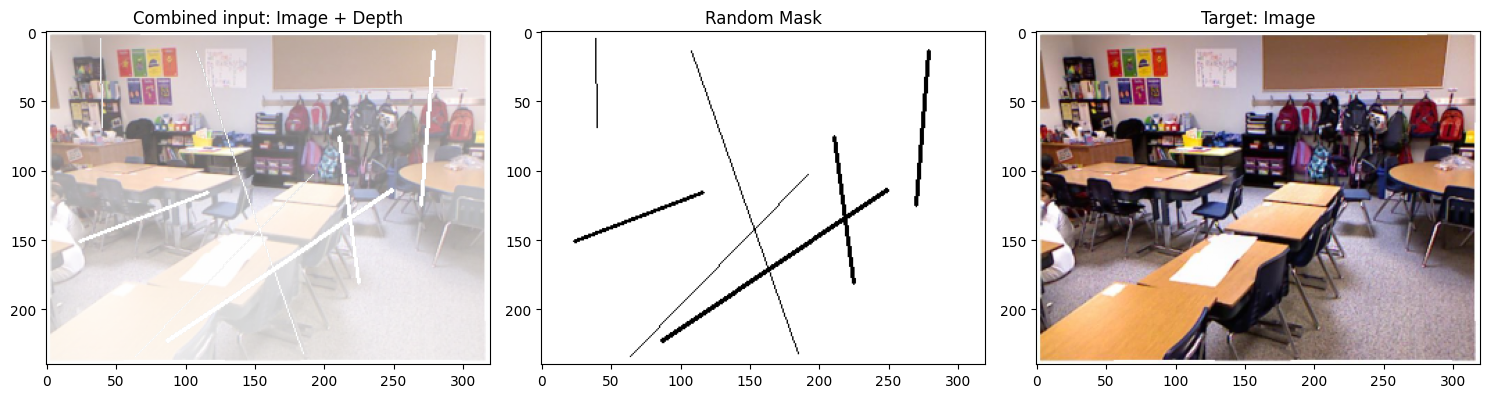

In [6]:
# Visualize first sample in the batch
show_sample(sample_batch, idx=0)

In [7]:
# Partial Convolution Based Autoencoder-Decoder Model"

In [8]:
class EncoderBlock(nn.Module):
    """
    Encoder block:
      - First PConv layer (stride=1) followed by ReLU.
      - Second PConv layer (stride=2, downsampling) followed by ReLU.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.pconv1 = PConv2d(in_channels, out_channels, 
                              kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels, out_channels, 
                              kernel_size=kernel_size, stride=2, padding=padding, bias=True)
    
    def forward(self, x, mask):
        # Ensure mask has shape (B, H, W) if it was (B, 1, H, W)
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        x1, mask1 = self.pconv1(x, mask)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2

class DecoderBlock(nn.Module):
    """
    Decoder block:
      - Upsamples input features and mask.
      - Concatenates the upsampled features with corresponding encoder (skip) features.
      - Applies two PConv layers with ReLU.
    """
    def __init__(self, in_channels, skip_channels, out_channels1, out_channels2, kernel_size=3, padding=1):
        super(DecoderBlock, self).__init__()
        self.pconv1 = PConv2d(skip_channels + in_channels, out_channels1, 
                              kernel_size=kernel_size, stride=1, padding=padding, bias=True)
        self.pconv2 = PConv2d(out_channels1, out_channels2, 
                              kernel_size=kernel_size, stride=1, padding=padding, bias=True)
    
    def forward(self, x, mask, skip_x, skip_mask):
        # Upsample feature map.
        x_up = F.interpolate(x, scale_factor=2, mode='nearest')
        # Process masks: squeeze if necessary, upsample, then squeeze back.
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        mask_up = F.interpolate(mask.unsqueeze(1), scale_factor=2, mode='nearest').squeeze(1)
        if skip_mask.dim() == 4 and skip_mask.size(1) == 1:
            skip_mask = skip_mask.squeeze(1)
        # Combine masks via maximum (logical OR).
        mask_cat = torch.max(skip_mask, mask_up)
        # Concatenate skip features with upsampled features along the channel dimension.
        x_cat = torch.cat([skip_x, x_up], dim=1)
        x1, mask1 = self.pconv1(x_cat, mask_cat)
        x1 = F.relu(x1)
        x2, mask2 = self.pconv2(x1, mask1)
        x2 = F.relu(x2)
        return x1, mask1, x2, mask2

class InpaintingModel_ImageDepth(nn.Module):
    """
    Inpainting model that follows a U-Net–like architecture using partial convolutions.
    It accepts a 4‑channel input (masked RGB + masked depth) and outputs a 3‑channel tensor (RGB).
    
    Architecture (mirroring your original Keras code):
      Encoder: 32, 64, 128, 256 filters.
      Decoder: [256->256, then 128], [128->128, then 64], [64->64, then 32], [32->32, then output channels].
      Final conv: Refines the output.
    """
    def __init__(self, input_channels=4, output_channels=3):
        super(InpaintingModel_ImageDepth, self).__init__()
        # Encoder layers
        self.enc1 = EncoderBlock(input_channels, 8)
        self.enc2 = EncoderBlock(8, 16)
        self.enc3 = EncoderBlock(16, 32)
        self.enc4 = EncoderBlock(32, 64)
        
        # Decoder: use same numbers as in your Keras __decoder_layer calls.
        self.dec1 = DecoderBlock(64, 64, 64, 32)
        self.dec2 = DecoderBlock(32, 32, 32, 16)
        self.dec3 = DecoderBlock(16, 16, 16, 8)
        self.dec4 = DecoderBlock(8, 8, 8, output_channels)
        
        self.final_conv = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
    
    def forward(self, x, mask):
        # Ensure mask shape is (B, H, W)
        if mask.dim() == 4 and mask.size(1) == 1:
            mask = mask.squeeze(1)
        
        # Encoder pass
        conv1, mask1, conv2, mask2 = self.enc1(x, mask)
        conv3, mask3, conv4, mask4 = self.enc2(conv2, mask2)
        conv5, mask5, conv6, mask6 = self.enc3(conv4, mask4)
        conv7, mask7, conv8, mask8 = self.enc4(conv6, mask6)
        
        # Decoder pass with skip connections
        conv9, mask9, conv10, mask10 = self.dec1(conv8, mask8, conv7, mask7)
        conv11, mask11, conv12, mask12 = self.dec2(conv10, mask10, conv5, mask5)
        conv13, mask13, conv14, mask14 = self.dec3(conv12, mask12, conv3, mask3)
        conv15, mask15, conv16, mask16 = self.dec4(conv14, mask14, conv1, mask1)
        
        out = self.final_conv(conv16)
        return torch.sigmoid(out)

In [9]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    """
    Dice coefficient metric.
    """
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + epsilon) / (y_true_f.sum() + y_pred_f.sum() + epsilon)

In [10]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(dataloader):
        # Get the combined 4-channel input and target.
        combined_input = batch["combined_input"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        
        optimizer.zero_grad()
        output = model(combined_input, mask)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * combined_input.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [11]:
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for batch in dataloader:
            combined_input = batch["combined_input"].to(device)
            mask = batch["mask"].to(device)
            target = batch["target"].to(device)
            
            output = model(combined_input, mask)
            loss = criterion(output, target)
            running_loss += loss.item() * combined_input.size(0)
            total_dice += dice_coef(target, output).item() * combined_input.size(0)
    avg_loss = running_loss / len(dataloader.dataset)
    avg_dice = total_dice / len(dataloader.dataset)
    return avg_loss, avg_dice

In [12]:
# Set up device, model, optimizer, and loss function.
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"); print(device)
model = InpaintingModel_ImageDepth(input_channels=4).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()  # Mean Absolute Error

cuda


c:\Users\user\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
num_epochs = 20
best_val_loss = float('inf')

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f}")
    
    # Save model when validation loss improves.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "nyu_inpainting_depth_best_model_v1.pth")
        print(f"Saved best model with Val Loss: {best_val_loss:.4f}")

100%|██████████| 2535/2535 [09:50<00:00,  4.29it/s]


Epoch 1/20 - Train Loss: 0.0533 | Val Loss: 0.0195 | Val Dice: 0.6348
Saved best model with Val Loss: 0.0195


100%|██████████| 2535/2535 [10:08<00:00,  4.16it/s]


Epoch 2/20 - Train Loss: 0.0167 | Val Loss: 0.0143 | Val Dice: 0.6365
Saved best model with Val Loss: 0.0143


100%|██████████| 2535/2535 [10:50<00:00,  3.90it/s]


Epoch 3/20 - Train Loss: 0.0142 | Val Loss: 0.0127 | Val Dice: 0.6373
Saved best model with Val Loss: 0.0127


100%|██████████| 2535/2535 [11:02<00:00,  3.83it/s]


Epoch 4/20 - Train Loss: 0.0129 | Val Loss: 0.0125 | Val Dice: 0.6387
Saved best model with Val Loss: 0.0125


100%|██████████| 2535/2535 [09:22<00:00,  4.51it/s]


Epoch 5/20 - Train Loss: 0.0119 | Val Loss: 0.0136 | Val Dice: 0.6392


100%|██████████| 2535/2535 [10:37<00:00,  3.98it/s]


Epoch 6/20 - Train Loss: 0.0112 | Val Loss: 0.0106 | Val Dice: 0.6373
Saved best model with Val Loss: 0.0106


100%|██████████| 2535/2535 [10:23<00:00,  4.06it/s]


Epoch 7/20 - Train Loss: 0.0104 | Val Loss: 0.0098 | Val Dice: 0.6375
Saved best model with Val Loss: 0.0098


100%|██████████| 2535/2535 [09:14<00:00,  4.57it/s]


Epoch 8/20 - Train Loss: 0.0100 | Val Loss: 0.0090 | Val Dice: 0.6376
Saved best model with Val Loss: 0.0090


100%|██████████| 2535/2535 [09:33<00:00,  4.42it/s]


Epoch 9/20 - Train Loss: 0.0096 | Val Loss: 0.0092 | Val Dice: 0.6370


100%|██████████| 2535/2535 [09:35<00:00,  4.40it/s]


Epoch 10/20 - Train Loss: 0.0094 | Val Loss: 0.0103 | Val Dice: 0.6371


100%|██████████| 2535/2535 [10:16<00:00,  4.11it/s]


Epoch 11/20 - Train Loss: 0.0090 | Val Loss: 0.0086 | Val Dice: 0.6384
Saved best model with Val Loss: 0.0086


100%|██████████| 2535/2535 [10:45<00:00,  3.93it/s]


Epoch 12/20 - Train Loss: 0.0088 | Val Loss: 0.0086 | Val Dice: 0.6372


100%|██████████| 2535/2535 [10:17<00:00,  4.11it/s]


Epoch 13/20 - Train Loss: 0.0085 | Val Loss: 0.0084 | Val Dice: 0.6391
Saved best model with Val Loss: 0.0084


100%|██████████| 2535/2535 [10:38<00:00,  3.97it/s]


Epoch 14/20 - Train Loss: 0.0085 | Val Loss: 0.0106 | Val Dice: 0.6349


100%|██████████| 2535/2535 [09:49<00:00,  4.30it/s]


Epoch 15/20 - Train Loss: 0.0083 | Val Loss: 0.0076 | Val Dice: 0.6377
Saved best model with Val Loss: 0.0076


100%|██████████| 2535/2535 [10:03<00:00,  4.20it/s]


Epoch 16/20 - Train Loss: 0.0082 | Val Loss: 0.0073 | Val Dice: 0.6378
Saved best model with Val Loss: 0.0073


100%|██████████| 2535/2535 [13:12<00:00,  3.20it/s]


Epoch 17/20 - Train Loss: 0.0080 | Val Loss: 0.0073 | Val Dice: 0.6382
Saved best model with Val Loss: 0.0073


100%|██████████| 2535/2535 [12:29<00:00,  3.38it/s]


Epoch 18/20 - Train Loss: 0.0079 | Val Loss: 0.0103 | Val Dice: 0.6364


100%|██████████| 2535/2535 [13:09<00:00,  3.21it/s]


Epoch 19/20 - Train Loss: 0.0078 | Val Loss: 0.0080 | Val Dice: 0.6375


100%|██████████| 2535/2535 [12:58<00:00,  3.25it/s]


Epoch 20/20 - Train Loss: 0.0077 | Val Loss: 0.0080 | Val Dice: 0.6375


cuda
Sample 0:
SSD between Inpainted vs GT: 1968.0701
SSD between Masked vs GT: 1670.8014
Sample 1:
SSD between Inpainted vs GT: 146.0597
SSD between Masked vs GT: 114.709946
Sample 2:
SSD between Inpainted vs GT: 966.94165
SSD between Masked vs GT: 2290.2788


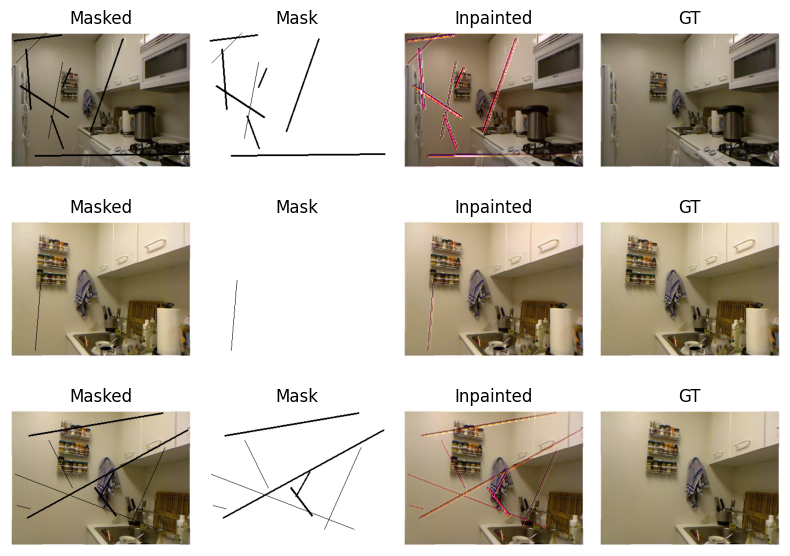

In [14]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = InpaintingModel_ImageDepth(input_channels=4).to(device)
model.load_state_dict(torch.load("nyu_inpainting_depth_best_model_v1.pth", map_location=device))
model.eval()

# Parameters for visualization.
sample_idx = 54  # starting index
rows = 3
samples = [test_dataset[i] for i in range(sample_idx, sample_idx + rows)]
combined_inputs = torch.stack([s["combined_input"] for s in samples], dim=0)   # shape: (rows, 4, H, W)
masks = torch.stack([s["mask"] for s in samples], dim=0)                       # shape: (rows, 1, H, W)
targets = torch.stack([s["target"] for s in samples], dim=0) # shape: (rows, 3, H, W)

# Get model predictions for each sample.
model.eval()
predictions = []
with torch.no_grad():
    for i in range(rows):
        # Add batch dimension.
        inp = combined_inputs[i].unsqueeze(0).to(device)
        mask = masks[i].unsqueeze(0).to(device)
        pred = model(inp, mask)  # Output: (1, 3, H, W)
        predictions.append(pred.squeeze(0).cpu())

# Plotting the results.
fig, axs = plt.subplots(nrows=rows, ncols=4, figsize=(8, 2*rows))

for i in range(rows):
    masked_color = combined_inputs[i][:3].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
    mask_np = masks[i].squeeze(0).cpu().numpy()
    inpainted_color = predictions[i][:3].permute(1, 2, 0).cpu().numpy()
    gt_color = targets[i][:3].permute(1, 2, 0).cpu().numpy()
    
    print(f"Sample {i}:")
    print("SSD between Inpainted vs GT:", np.sum((inpainted_color - gt_color)**2))
    print("SSD between Masked vs GT:", np.sum((masked_color - gt_color)**2))
    
    # Plot columns:
    # Column 0: Masked Color Image.
    axs[i, 0].imshow(masked_color)
    axs[i, 0].set_title("Masked")
    axs[i, 0].axis("off")
    
    axs[i, 1].imshow(mask_np, cmap="gray")
    axs[i, 1].set_title("Mask")
    axs[i, 1].axis("off")
    
    axs[i, 2].imshow(inpainted_color)
    axs[i, 2].set_title("Inpainted")
    axs[i, 2].axis("off")
    
    axs[i, 3].imshow(gt_color)
    axs[i, 3].set_title("GT")
    axs[i, 3].axis("off")

plt.tight_layout()
plt.show()